In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/BTP/Wheat

/content/gdrive/.shortcut-targets-by-id/1-luJs84Eus8d8yDA1W4a4Dr54I7ve4nP/BTP/Wheat


# Data Prep

#### Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pathlib
from tqdm.notebook import tqdm
import pickle 
import shutil
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

import cv2
from skimage.io import imread as sk_imread, imshow as sk_imshow
from skimage.transform import resize as sk_resize

import tensorflow as tf
import tensorflow_hub as hub
%load_ext tensorboard
import warnings
warnings.filterwarnings('ignore')

In [ ]:
DATA_DIR = 'dataset'

def get_file_paths(main_dir):
  file_paths = {}
  for root, dir, files in os.walk(main_dir):
    if root == main_dir:
      continue
    class_damage = os.path.basename(root)
    file_paths[class_damage] = [os.path.join(root, filename) for filename in files]
  return file_paths

FILE_PATHS = get_file_paths(DATA_DIR)
print('classes found: ', FILE_PATHS.keys())
print('sample path:', FILE_PATHS['Shrivel'][0])

classes found:  dict_keys(['Healthy', 'Shrivel', 'Black', 'Chalky', 'Green'])
sample path: dataset/Shrivel/S01198.JPG


In [ ]:
print('count of images in each class')
print('*'*30)
count = 0
for damage in FILE_PATHS.keys():
  print(damage, len(FILE_PATHS[damage]))
  count += len(FILE_PATHS[damage])

print('')
print('Total images', count)

count of images in each class
******************************
Healthy 2099
Shrivel 2081
Black 2065
Chalky 2076
Green 2076

Total images 10397


#### Importing Files

In [ ]:
with open('pickled_df.pkl', 'rb') as f: df = pickle.load(f)
with open('pickled_X.pkl', 'rb') as f: X = pickle.load(f)

print(df.shape)
print(X.shape)

(10397, 2)
(10397, 300, 200, 3)


In [ ]:
#df['class'].replace(['half-chalky', 'full-chalky'], 'chalky', inplace=True)
#df['class'].value_counts()

In [ ]:
#One Hot Encoding of labels
from sklearn.preprocessing import OneHotEncoder

y = df['class']
OHE = OneHotEncoder(sparse=False)
y = OHE.fit_transform(np.array(y).reshape(-1,1))
print(y.shape)
OHE_classes = OHE.categories_[0]
OHE_classes

(10397, 5)


array(['Black', 'Chalky', 'Green', 'Healthy', 'Shrivel'], dtype=object)

**Important**: Set a seed in train_test_split for reproducibility. When dividing data into train and test

In [ ]:
from sklearn.model_selection import train_test_split

SEED = 42

#Indices of train and test df should be 6402, 3732, 2446.. and 5614, 5099, 5763..  
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.3, random_state=SEED)
df_train, df_test = train_test_split(df, stratify=y, shuffle=True, test_size=0.33, random_state=SEED)

print(df_train.index[:3],df_test.index[:3])

Int64Index([817, 5442, 10322], dtype='int64') Int64Index([6133, 10295, 3941], dtype='int64')


In [ ]:
print('df_train shape', df_train.shape)
print('df_test shape', df_test.shape, '\n')
print('X_train, y_train shape', X_train.shape, y_train.shape)
print('X_test, y_test shape', X_test.shape, y_test.shape)

df_train shape (6965, 2)
df_test shape (3432, 2) 

X_train, y_train shape (7277, 300, 200, 3) (7277, 5)
X_test, y_test shape (3120, 300, 200, 3) (3120, 5)


In [ ]:
print(df_train['class'].value_counts(), '\n') 
print(df_test['class'].value_counts())

Healthy    1406
Shrivel    1394
Green      1391
Chalky     1391
Black      1383
Name: class, dtype: int64 

Healthy    693
Shrivel    687
Green      685
Chalky     685
Black      682
Name: class, dtype: int64


Sanity Check: 

Images at same indice in both X_trian and df_train should be same. This way we have a track of the path for every image found in X_trian

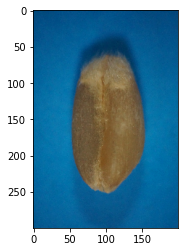

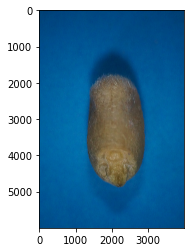

In [ ]:
ind = np.random.randint(0, len(df_train))

plt.imshow(X_train[ind])
plt.show()
plt.imshow(sk_imread(df_train['path'].iloc[ind]))
plt.show()

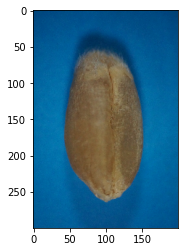

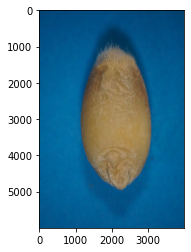

In [ ]:
ind = np.random.randint(0, len(df_test))

plt.imshow(X_test[ind])
plt.show()
plt.imshow(sk_imread(df_test['path'].iloc[ind]))
plt.show()

#### Preaparing the Input Pipeline

Reference: 

https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification
https://www.pyimagesearch.com/2021/06/21/data-pipelines-with-tf-data-and-tensorflow/

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
for image, label in train_dataset.take(1):
  print(image.shape, label.shape) 

(300, 200, 3) (5,)


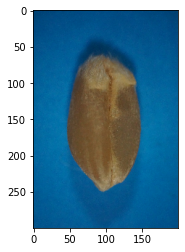

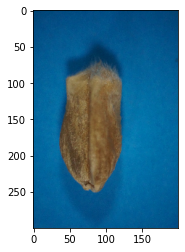

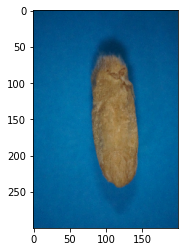

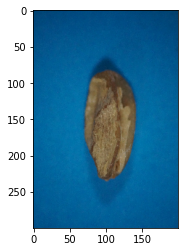

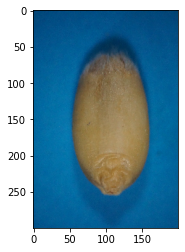

In [ ]:
for image, label in train_dataset.take(5):
  plt.imshow(image)
  plt.show()

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 300
IMG_WIDTH = 200

#Train
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

#Test
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

# Error Analysis

In [ ]:

def get_class(y):
  """
  Returns the class with highest probability
  Input: y: shape(n_datapoints, n_classes)
  output: y_class: shape(n_datapoints)
  """
  y = np.argmax(y, axis=1)
  y = OHE_classes[y]
  return y

def show_confusion_matrix(class_true, class_pred):
  """
  Input Shape: (n_datapoints, )
  class_true contains true class in string format. 
  """
  cm = confusion_matrix(class_true, class_pred)
  cm = (cm.T / np.sum(cm, axis=1)).T
  cm = cm*100
  plt.figure(figsize=(18, 16))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu");
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(OHE_classes); ax.yaxis.set_ticklabels(OHE_classes);

def get_highest(row):
  """
  Given a row of probabilities, it gives the class with highest probability
  """
  ind = np.argmax(row)
  damage = OHE_classes[ind]
  score = row[damage]
  return (damage, score)
 
def get_second_highest(row):
  """
  Given a row of probabilities, it gets the class with second highest probability
  """
  ind = np.argsort(row)[-2]
  damage = OHE_classes[ind]
  score = row[damage]
  return (damage, score)

def get_detailed_df(type_):
  if type_ == 'test':
    temp_test = pd.DataFrame(y_pred_test, columns=OHE_classes, index=df_test.index)
    temp2 = temp_test.copy()
    temp_test['highest'] = temp2.apply(lambda row: get_highest(row), axis=1)
    temp_test['second_highest'] = temp2.apply(lambda row: get_second_highest(row), axis=1)
    temp_test['true_class'] = df_test['class'].values
    temp_test['pred_class'] = temp_test['highest'].apply(lambda x: x[0])
    temp_test = temp_test[['true_class', 'pred_class', 'highest', 'second_highest']]
    temp_test['is_correct'] = temp_test.apply(lambda x: True if x['highest'][0] == x['true_class'] else False, axis=1)
    temp_test['index_to_X'] = range(0, len(temp_test))
    return temp_test

  elif type_=='train':
    temp_train = pd.DataFrame(y_pred_train, columns=OHE_classes, index=df_train.index)
    temp2 = temp_train.copy()
    temp_train['highest'] = temp2.apply(lambda row: get_highest(row), axis=1)
    temp_train['second_highest'] = temp2.apply(lambda row: get_second_highest(row), axis=1)
    temp_train['true_class'] = df_train['class'].values
    temp_train['pred_class'] = temp_train['highest'].apply(lambda x: x[0])
    temp_train = temp_train[['true_class', 'pred_class', 'highest', 'second_highest']]
    temp_train['is_correct'] = temp_train.apply(lambda x: True if x['highest'][0] == x['true_class'] else False, axis=1)
    temp_train['index_to_X'] = range(0, len(temp_train))
    return temp_train

  else: 
    print('Error: Put valid type')

In [ ]:
# %tensorboard --logdir logs/fit

### Evaluation

In [ ]:
!pip install -U git+https://github.com/qubvel/efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-kqzhmhqq
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-kqzhmhqq
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=0585ecc8d238c073e0d5e7dc7c1e3d9743a8eb0f391a92777c5f244307153270
  Stored in directory: /tmp/pip-ephem-wheel-cache-ty36zjk5/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [ ]:
model = tf.keras.models.load_model('models/VGG16/model.h5')

In [ ]:
steps_per_epoch = len(df_train) // BATCH_SIZE
validation_steps = len(df_test) // BATCH_SIZE

print('test: ', model.evaluate(test_dataset, steps=validation_steps, verbose=0))
print('train:', model.evaluate(train_dataset, steps=steps_per_epoch, verbose=0))

test:  [0.030801596119999886, 0.9926282167434692]
train: [0.03206000477075577, 0.9900633692741394]


* y_pred_test and y_pred_train contain the predictions in probabilities, with shape (n_datapoints, n_classes). class_pred_train and class_pred_test containns predictions of classes in string format, with shape (n_datapoints, )

In [ ]:
y_pred_test = model.predict(X_test)
class_pred_test = get_class(y_pred_test)

y_pred_train = model.predict(X_train)
class_pred_train = get_class(y_pred_train)

class_true_test = get_class(y_test)
class_true_train = get_class(y_train)

In [ ]:
from sklearn.metrics import log_loss

acc_train = np.mean(class_pred_train == class_true_train)
acc_test = np.mean(class_pred_test == class_true_test)

print('Train: Accuracy', acc_train, 'log_loss', log_loss(y_train, y_pred_train))
print('Test:  Accuracy', acc_test, 'log_loss', log_loss(y_test, y_pred_test))

Train: Accuracy 0.9899683935687783 log_loss 0.0320602872844068
Test:  Accuracy 0.9926282051282052 log_loss 0.03080159075536263


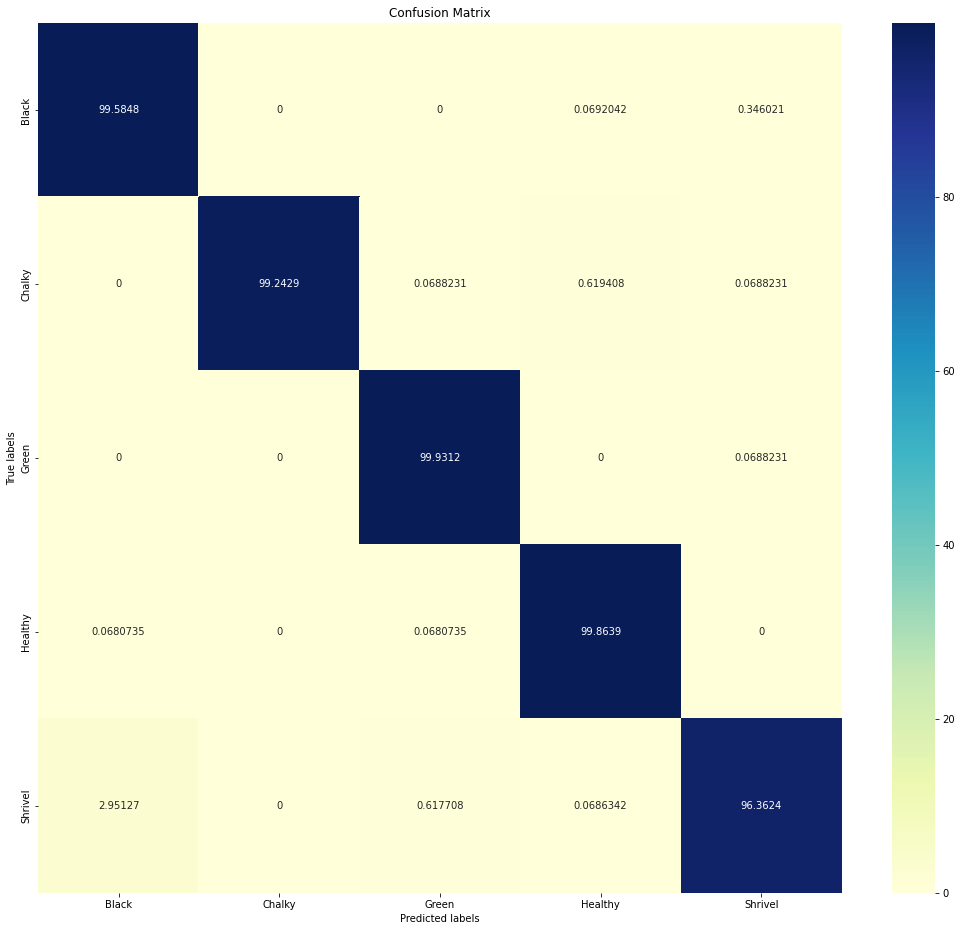

In [ ]:
show_confusion_matrix(class_true_train, class_pred_train)

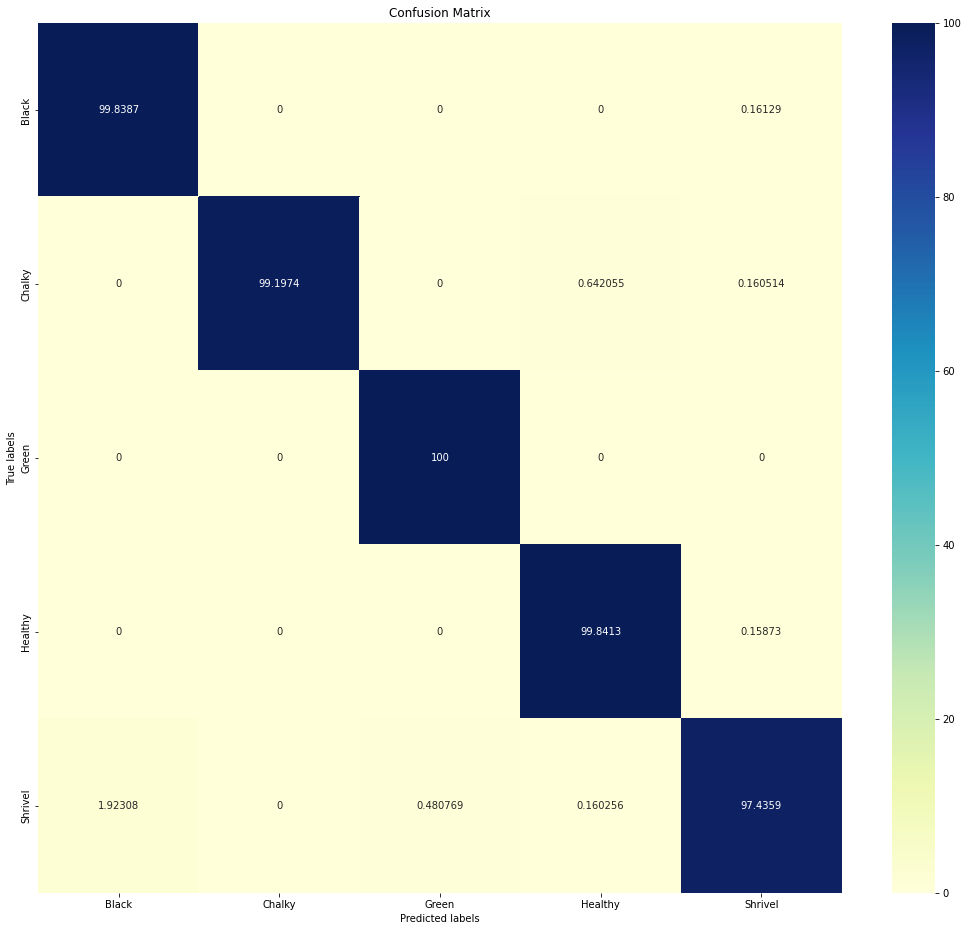

In [ ]:
show_confusion_matrix(class_true_test, class_pred_test)

### Prediction Time

In [ ]:
def predict_sanity(img_path):
  img = cv2.resize(sk_imread(img_path), (IMG_WIDTH, IMG_HEIGHT))
  y = model.predict(img[np.newaxis, :, :, :])
  return OHE_classes[np.argmax(y)], y[0]

In [ ]:
ind = np.random.randint(0, len(df))
path = df['path'].iloc[ind]
print(path)

predict_sanity(path)

dataset/Shrivel/S00173.JPG


('Shrivel', array([1.8834940e-04, 5.9699645e-09, 3.7390321e-12, 3.1335209e-11,
        9.9981171e-01], dtype=float32))

In [ ]:


path = df['path'].iloc[ind]
print(path)

predict_sanity(path)

dataset/Shrivel/S00173.JPG


('Shrivel', array([1.8834940e-04, 5.9699645e-09, 3.7390321e-12, 3.1335209e-11,
        9.9981171e-01], dtype=float32))

In [ ]:
path = df['path'].iloc[ind]
print(path)

predict_sanity(path)

dataset/Shrivel/S00173.JPG


('Shrivel', array([1.8834940e-04, 5.9699645e-09, 3.7390321e-12, 3.1335209e-11,
        9.9981171e-01], dtype=float32))

Average Predictions Time

In [ ]:
def avg_pred_time(batch_size, N):
  inds = np.random.randint(1, len(df), batch_size)
  batch = X[inds]
  start = time.time()
  for i in range(N):
    model.predict(batch)
  end = time.time()
  t = end-start
  return round(t/N, 3)

In [ ]:
N = 10
print('Average time over {} rounds for a batch size of {} is {} s'.format(N, 16, avg_pred_time(16, N)))
print('Average time over {} rounds for a batch size of {} is {} s'.format(N, 64, avg_pred_time(64, N)))
print('Average time over {} rounds for a batch size of {} is {} s'.format(N, 128, avg_pred_time(128, N)))
print('Average time over {} rounds for a batch size of {} is {} s'.format(N, 256, avg_pred_time(256, N)))
print('Average time over {} rounds for a batch size of {} is {} s'.format(N, 512, avg_pred_time(512, N)))
print('Average time over {} rounds for a batch size of {} is {} s'.format(N, 1028, avg_pred_time(1028, N)))

Average time over 10 rounds for a batch size of 16 is 0.163 s
Average time over 10 rounds for a batch size of 64 is 0.563 s
Average time over 10 rounds for a batch size of 128 is 1.029 s
Average time over 10 rounds for a batch size of 256 is 2.381 s
Average time over 10 rounds for a batch size of 512 is 3.623 s
Average time over 10 rounds for a batch size of 1028 is 8.669 s


### Misclassified Points

In [ ]:
detailed_df_test = get_detailed_df('test') 
detailed_df_train = get_detailed_df('train') 

ValueError: ignored

In [ ]:

damage = 'healthy'

print('##########################################################################')
print('############################# TEST #######################################')
print('##########################################################################')
print('')

incorrect_preds = detailed_df_test[detailed_df_test['is_correct']==False]
incorrect_preds = incorrect_preds[incorrect_preds['true_class']==damage]

for i, row in incorrect_preds.iterrows():
  print('index:{} --> path:{}'.format(i, df_test['path'][i]))
  print('True Class:', row['true_class'])
  print('Predicted Class: {} ({:.3f})'.format(row['pred_class'], row['highest'][1]))
  print('Second highest prediction: {} ({:.3f})'.format(row['second_highest'][0], row['second_highest'][1]))
  plt.figure(figsize=(24, 12))
  plt.imshow(X_test[row['index_to_X']])
  plt.show()
  print('')

print('##########################################################################')
print('############################# TRAIN ######################################')
print('##########################################################################')
print('')

incorrect_preds = detailed_df_train[detailed_df_train['is_correct']==False]
incorrect_preds = incorrect_preds[incorrect_preds['true_class']==damage]

for i, row in incorrect_preds.iterrows():
  print('index:{} --> path:{}'.format(i, df_train['path'][i]))
  print('True Class:', row['true_class'])
  print('Predicted Class: {} ({:.3f})'.format(row['pred_class'], row['highest'][1]))
  print('Second highest prediction: {} ({:.3f})'.format(row['second_highest'][0], row['second_highest'][1]))
  plt.figure(figsize=(24, 12))
  plt.imshow(X_train[row['index_to_X']])
  plt.show()
  print('')

### Fixing a Threshold

Stats

In [ ]:
threshold = 0.99

detailed_df_test = get_detailed_df('test') 
detailed_df_train = get_detailed_df('train') 

detailed_df_test['smaller_than_thresh'] = detailed_df_test['highest'].apply(lambda x: x[1] < threshold)
print('########################### TEST STATS ############################## \n')
for damage in OHE_classes:
  temp = detailed_df_test[detailed_df_test['true_class']==damage]
  print('->',damage)
  temp2 = temp[temp['smaller_than_thresh']==False]
  print('Number of predictions with prob > {} = {} out of {}'.format(threshold, len(temp2), len(temp)))
  print('Out of them, correct number of predictions = {}'.format(sum(temp2['is_correct'])))
  incorrect_pred = temp[temp['is_correct']==False]
  print('Total number of incorrect predictions =', len(incorrect_pred))
  print('Out of them number of incorrect predictions with prob > threshold =', len(incorrect_pred[incorrect_pred['smaller_than_thresh']==False]))
  print('')

print('########################### TRAIN STATS ############################## \n')
detailed_df_train['smaller_than_thresh'] = detailed_df_train['highest'].apply(lambda x: x[1] < threshold)
for damage in OHE_classes:
  temp = detailed_df_train[detailed_df_train['true_class']==damage]
  print('->',damage)
  temp2 = temp[temp['smaller_than_thresh']==False]
  print('Number of predictions with prob > {} = {} out of {}'.format(threshold, len(temp2), len(temp)))
  print('Out of them, correct number of predictions = {}'.format(sum(temp2['is_correct'])))
  incorrect_pred = temp[temp['is_correct']==False]
  print('Total number of incorrect predictions =', len(incorrect_pred))
  print('Out of them number of incorrect predictions with prob > threshold =', len(incorrect_pred[incorrect_pred['smaller_than_thresh']==False]))
  print('')

Test (Prob < Threshold)

In [ ]:
damage = 'pin-damage'

damage_df = detailed_df_test[detailed_df_test['true_class']==damage]

for i, row in damage_df.iterrows():
  if row['highest'][1] < threshold:
    print('index:{} --> path:{}'.format(i, df_test['path'][i]))
    print('True Class:', row['true_class'])
    print('Predicted Class: {} ({:.3f})'.format(row['pred_class'], row['highest'][1]))
    print('Second highest prediction: {} ({:.3f})'.format(row['second_highest'][0], row['second_highest'][1]))
    plt.figure(figsize=(24, 12))
    plt.imshow(X_test[row['index_to_X']])
    plt.show()
    print('')

Train (Prob < Threshold)

In [ ]:
damage_df = detailed_df_train[detailed_df_train['true_class']==damage]

for i, row in damage_df.iterrows():
  if row['highest'][1] < threshold:
    print('index:{} --> path:{}'.format(i, df_train['path'][i]))
    print('True Class:', row['true_class'])
    print('Predicted Class: {} ({:.3f})'.format(row['pred_class'], row['highest'][1]))
    print('Second highest prediction: {} ({:.3f})'.format(row['second_highest'][0], row['second_highest'][1]))
    plt.figure(figsize=(24, 12))
    plt.imshow(X_train[row['index_to_X']])
    plt.show()
    print('')